# Kmeans++

**Author:**  Jhosimar George Arias Figueroa

This notebook contains a **pytorch** implementation of the Kmeans++ clustering algorithm.

## Install Pytorch

In [1]:
!pip install torch

## Import Libraries

In [0]:
import numpy as np
import sklearn
from itertools import cycle, islice
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn import datasets
%matplotlib inline

## Hyperparameters

In [0]:
SEED = 1
CUDA = 0
MAX_IT = 500

In [0]:
np.random.seed(SEED)
torch.manual_seed(SEED)
if CUDA:
  torch.cuda.manual_seed(SEED)

## Load Datasets

In [0]:
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

datasets = [ (noisy_circles, 2), (noisy_moons, 2), (blobs, 3), (no_structure, 3) ]

## Kmeans++

In [0]:
class KmeansPP:
  
  def __init__(self, n_clusters, max_it, cuda=False):
    self.n_clusters = n_clusters
    self.max_it = max_it  
    self.cuda = cuda
  
  def initialize_centroids(self, X):
    n_elem, n_feat = X.size()
    n_clusters = self.n_clusters
    self.centroid = torch.zeros([n_clusters, n_feat], dtype=torch.float)
    if self.cuda:
      self.centroid = self.centroid.cuda()
    # initial centroid is chosen randomly from data
    initial_index = torch.randint(0, n_elem, [1])[0]
    self.centroid[0] = X[initial_index]
    # choose new centroids
    for i in range(1, n_clusters):
      # calculate distances w.r.t. calculated centroids
      D = torch.pow(X - self.centroid[0],2).sum(-1)
      for j in range(1, i):
        D = torch.min(D, torch.pow(X - self.centroid[j],2).sum(-1))
      # define a probability distribution
      probs = D/torch.sum(D) #[num_elem, num_clusters]
      # sample from the discrete probability distribution
      prob_dist = torch.distributions.Categorical(probs)
      sample_index = prob_dist.sample()
      # assign centroid according to the sampled index
      self.centroid[i] = X[sample_index]
    return self.centroid
  
  
  def get_assignments(self, X):
    # add dimension=1 at the specified position
    _C = self.centroid.unsqueeze(0)   #[1, num_centers, num_feat]
    _X = X.unsqueeze(1)               #[num_elem, 1, num_feat]
    # euclidean distance of each input w.r.t. each centroid
    D = torch.pow(_X - _C, 2).sum(-1) #[num_elem, num_centers]
    # obtain assignments
    self.assignment = D.argmin(-1)  
    return self.assignment
  
  
  def update_centroids(self, X, assignments):
    n_feat = X.size()[-1]
    y = assignments
    # count number of elements per centroid
    num_elem_centroid = torch.bincount(y).type(torch.float) 
    # add the value of each feature dimension into its respective centroid
    for i in range(n_feat):
      self.centroid[:, i] = torch.bincount(y, weights=X[:,i])/num_elem_centroid
    
    
  def fit(self, X):
    if self.cuda:
      X = X.cuda()
    # initialize centroids
    self.initialize_centroids(X)
    # iterate according to the given max_it parameter
    for i in range(self.max_it):
      # calculate assignments
      assignments = self.get_assignments(X)
      # update centroids
      self.update_centroids(X, assignments)
    

## Plot centroid initialization

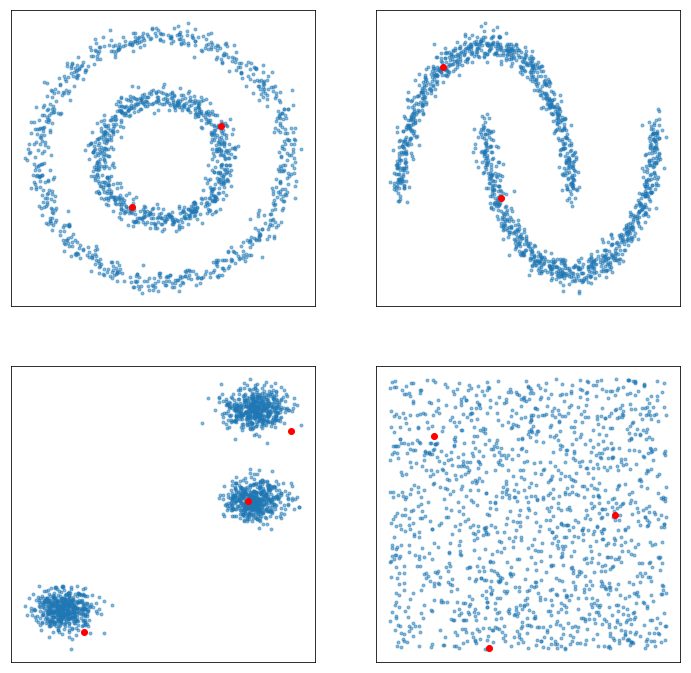

In [7]:
plt.figure(figsize=(12, 12))
for i, (dataset, num_clusters) in enumerate(datasets):
  _X, _y = dataset
  
  X = torch.tensor(_X).type(torch.float)
  if CUDA:
    X = X.cuda()
  kmeans = KmeansPP(num_clusters, MAX_IT, CUDA)
  C = kmeans.initialize_centroids(X)
  centroids = C.cpu().numpy()
  
  plt.subplot(2,2,i + 1)
  plt.plot(zip(*_X)[0], zip(*_X)[1], '.', alpha=0.5)
  plt.plot(zip(*centroids)[0], zip(*centroids)[1], 'ro')
  plt.xticks(())
  plt.yticks(())

## Clustering

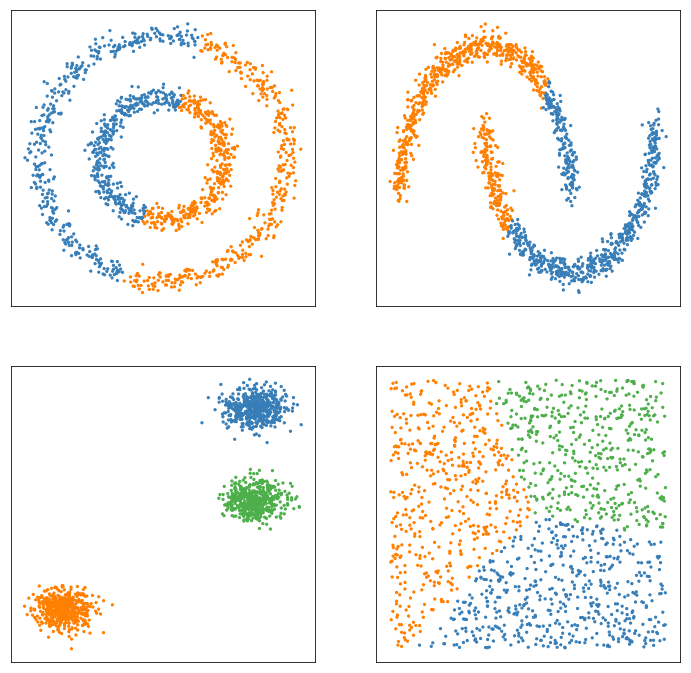

In [8]:
plt.figure(figsize=(12, 12))
for i, (dataset, num_clusters) in enumerate(datasets):
  _X, _y = dataset
  
  X = torch.tensor(_X).type(torch.float)
  kmeans = KmeansPP(num_clusters, MAX_IT, CUDA)
  kmeans.fit(X)
  
  y_pred = kmeans.assignment.cpu().numpy()
  
  plt.subplot(2,2,i + 1)
  colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                       '#f781bf', '#a65628', '#984ea3',
                                       '#999999', '#e41a1c', '#dede00']),
                                int(max(y_pred) + 1))))
  plt.scatter(_X[:, 0], _X[:, 1], s=5, color=colors[y_pred])
  plt.xticks(())
  plt.yticks(())
  
  